In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import joblib 

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

from create_toybrains import ToyBrainsData
from utils.vizutils import *
from utils.configutils import *

### Load the baseline results

In [13]:
N_SAMPLES  = 10000
basefilename = 'lblmidr_covsite'
config_dirname = ''

##### generate the baseline results on generated datasets using parallel processes

In [14]:
def generate_baseline_results(dataset):    
    # get the related config file
    dataset_unique_id = dataset.rstrip('/').split('/')[-1].split(f'n{N_SAMPLES}_')[-1]
    config_file = glob(f"configs/*{dataset_unique_id}*.py")
    assert len(config_file)==1, f"couldn't find the config file used to generate the dataset with unique ID '{dataset_unique_id}'. \nFound {config_file}"
    config_file = config_file[0]

    # init the ToyBrainsData instance
    toy = ToyBrainsData(config=config_file)
    toy.load_generated_dataset(dataset)
    bl_result = toy.fit_contrib_estimators(
            input_feature_sets=["attr_all", "attr_subsets", "cov_all"],
            output_labels=["lbls"], 
            CV=10, 
            metric_name='r2',
            debug=False,
            verbose=0)
    return bl_result

In [15]:
#  generate the baseline results on generated datasets using parallel processes
# bl_results = joblib.Parallel(n_jobs=20)(
#     joblib.delayed(
#         generate_baseline_results)(dataset) for dataset in tqdm(
#             glob(f"dataset/*n{N_SAMPLES}_*{basefilename}*/"))
#             )
    

##### Alternatively, just load the baseline results if they were already generated


In [16]:
# alternatively just load the baseline results if they were already generated
bl_results = []
for results_file in glob(f'experiments/{basefilename}*/dataset/*n{N_SAMPLES}_*{basefilename}*/baseline_results/run.csv'):
    df = pd.read_csv(results_file)
    bl_results.append(df)

print(f"loaded {len(bl_results)} configs with basefilename={basefilename} & sample_size={N_SAMPLES}")

loaded 5 configs with basefilename=lblmidr_covsite & sample_size=10000


### See the baseline results

In [17]:
show_contrib_table(bl_results)

All results are shown in percentage (%)


In [18]:
# filter specific rows and columns from the table
df = show_contrib_table(
                   bl_results, 
                   avg_over_trials=True,
                   filter_rows={'out':['lbl_lesion'], 'inp':['attr_all']}, 
                   filter_cols=['test_metric']
                   )
df

All results are shown in percentage (%)


### Further plot the results
tailored to the application

In [32]:
# regenerate without averaging over all trials rows and all input groups
df = show_contrib_table(
                   bl_results, 
                   avg_over_trials=False,
                   filter_rows={'out':['lbl_lesion']}, 
                   filter_cols=['test_metric']
                   )

All results are shown in percentage (%)


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


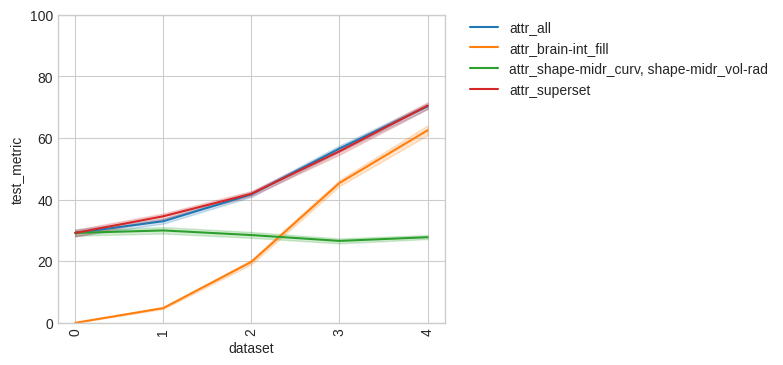

In [36]:
fig, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x='dataset', y='test_metric', data=df.data.reset_index(),
             hue='inp' ,
             legend=True, 
             ax=ax)
ax.set_ylim(0,100)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
# set the legend outside the plot and frame on
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()